# 04 — Counts · Blue Health **Exposure Metrics**

Notebook adaptat per analitzar **activitats**. Rutes **relatives** i càrrega robusta del fitxer `.p`.


In [1]:
# --- Setup relatiu i càrrega robusta del Counts (activities) ---
from pathlib import Path
import pickle, re, json
import numpy as np
import pandas as pd
from lisc.utils import load_object

def find_repo_root(start: Path | None = None) -> Path:
    p = (start or Path.cwd()).resolve()
    while p != p.parent:
        if (p / '.git').exists() or (p / 'counts').exists() or (p / 'data').exists():
            return p
        p = p.parent
    raise RuntimeError('No s\'ha trobat l\'arrel del repo.')

REPO_ROOT = find_repo_root()
BASE_NAME = 'counts_blue_health_exposure_metrics'
CANDIDATES = [
    REPO_ROOT / 'counts' / f'{BASE_NAME}.p',
    REPO_ROOT / 'data' / 'counts' / f'{BASE_NAME}.p',
    REPO_ROOT / 'data' / f'{BASE_NAME}.p',
]

def resolve_counts_path():
    for p in CANDIDATES:
        if p.exists():
            return p
    found = list(REPO_ROOT.rglob('counts_*.p'))
    for fp in found:
        if 'exposure_metrics' in fp.name:
            return fp
    raise FileNotFoundError('No s\'ha trobat el fitxer de counts per activities.')

def load_counts_safe(p: Path):
    try:
        return load_object(p.stem, directory=str(p.parent))
    except Exception as e:
        print('[warn] load_object ha fallat →', e)
        with open(p, 'rb') as fh:
            return pickle.load(fh)

counts_path = resolve_counts_path()
print('Usant counts:', counts_path.relative_to(REPO_ROOT))
counts = load_counts_safe(counts_path)

N_TERMS = 3
N_DROP  = 100

try:
    nA, nB = counts.counts.shape
    n_drop = min(N_DROP, max(nA-1, 0), max(nB-1, 0))
    if n_drop > 0:
        counts.drop_data(n_drop)
except Exception as e:
    print('[warn] drop_data omès:', e)

counts.compute_score('normalize', dim='A')
A_labels = list(counts.terms['A'].labels)
B_labels = list(counts.terms['B'].labels)
score    = np.array(counts.score, copy=False)
df = pd.DataFrame(score, index=A_labels, columns=B_labels)
df.head()


Usant counts: counts/counts_blue_health_activities.p
[warn] load_object ha fallat → Can not find requested file name.


,contemplation of water,sitting by the sea,mindfulness by the sea,coastal strolling,birdwatching (coastal),rockpooling,beach clean-up,wading,sea dipping,sunbathing (marine setting),...,open-water swimming (training),sea kayaking expedition,stand-up paddle downwinding,surfing,windsurfing,scuba diving (recreational),apnea,spearfishing (apnea-based),coastal rowing (competitive),motorized water sports
Mental health,0.000126,0.000005,0.000028,0.000042,0.0,0.000001,0.000000,0.000003,0.000001,0.0,...,0.000004,0.000003,0.000001,0.000076,0.000000,0.000028,0.004203,0.0,0.000000e+00,0.000031
Affect balance,0.000280,0.000008,0.000093,0.000047,0.0,0.000000,0.000016,0.000000,0.000008,0.0,...,0.000008,0.000000,0.000000,0.000093,0.000000,0.000054,0.004639,0.0,0.000000e+00,0.000124
Psychological distress,0.000144,0.000000,0.000080,0.000023,0.0,0.000000,0.000000,0.000006,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000046,0.000000,0.000034,0.004386,0.0,0.000000e+00,0.000006
Perceived stress,0.000173,0.000007,0.000206,0.000018,0.0,0.000011,0.000006,0.000008,0.000027,0.0,...,0.000009,0.000002,0.000000,0.000045,0.000008,0.000101,0.001888,0.0,8.756452e-07,0.000074
Anxiety,0.000167,0.000007,0.000051,0.000020,0.0,0.000000,0.000000,0.000000,0.000014,0.0,...,0.000014,0.000000,0.000000,0.000116,0.000000,0.000061,0.003302,0.0,0.000000e+00,0.000058


In [2]:
# --- Exportacions per a ACTIVITIES ---
summary_dir = counts_path.parent / 'summary' / 'exposure_metrics'
assocs_dir  = counts_path.parent / 'assocs'  / 'exposure_metrics'
summary_dir.mkdir(parents=True, exist_ok=True)
assocs_dir.mkdir(parents=True, exist_ok=True)

csv_path = summary_dir / 'blue_health_exposure_scores.csv'
df.to_csv(csv_path)
print('Scores →', csv_path)
print('\nSummary stats:\n', df.describe())

def top_indices_desc(arr, k):
    return np.argsort(arr)[::-1][:k]

for i, a_lab in enumerate(A_labels):
    order = top_indices_desc(score[i, :], N_TERMS)
    top_b = [B_labels[j] for j in order]
    safe_name = re.sub(r'[^\w\-\. ]', '_', a_lab) + '.json'
    with open(summary_dir / safe_name, 'w', encoding='utf-8') as f:
        json.dump({'top_assocs': top_b}, f, ensure_ascii=False)

assocs = {}
for j, b_lab in enumerate(B_labels):
    order = top_indices_desc(score[:, j], N_TERMS)
    assocs[b_lab] = [A_labels[i] for i in order]
with open(assocs_dir / 'associations.json', 'w', encoding='utf-8') as f:
    json.dump(assocs, f, ensure_ascii=False)

print('Export complet.')


Scores → /Users/davidgallardo-pujol/Documents/GitHub/BlueHealthKnowledge/counts/summary/activities/blue_health_activity_scores.csv

Summary stats:
        contemplation of water  sitting by the sea  mindfulness by the sea  \
count               59.000000           59.000000               59.000000   
mean                 0.000407            0.000010                0.000212   
std                  0.000878            0.000019                0.000530   
min                  0.000026            0.000000                0.000000   
25%                  0.000097            0.000000                0.000029   
50%                  0.000155            0.000003                0.000066   
75%                  0.000281            0.000011                0.000141   
max                  0.004484            0.000100                0.003743   

       coastal strolling  birdwatching (coastal)  rockpooling  beach clean-up  \
count          59.000000            5.900000e+01    59.000000       59.000000

# Counts Analysis with Activities Associations

Co-occurrence of terms analysis: check how often pre-selected Activities terms appear in abstracts with risk factor terms. 

This analysis searches through PubMed for papers that contain specified risk factors and selected association terms.

Data extracted is the count of the number of papers with both terms. This is used to infer the associated terms for each risk factor.

This notebook covers the Activities-related association terms.

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import normaltest, spearmanr

from lisc import Counts
from lisc.utils import SCDB, load_object
from lisc.io import load_txt_file
from lisc.plts.counts import plot_matrix, plot_clustermap, plot_dendrogram

In [4]:
import seaborn as sns
sns.set_context('talk')

In [5]:
# Import custom project code
import sys
sys.path.append('../code')
from plts import plot_count_hist, plot_time_associations, plot_latency_values
from analysis import get_time_associations

## Setup

In [6]:
# Notebook settings
SAVE_FIG = True
SAVE_EXT = '.pdf'

# Set some plot settings for when saving out
#   This is because changing these looks a bit odd in the notebook
matrix_linewidths = 0.35 if SAVE_FIG else 0

In [7]:
# Analysis settings
# Minimum number of articles a risk factor must have to be represented

N_RISK_FACTORS = 1000  

In [8]:
# Set the file locations
term_dir = '../terms/'
figs_dir = '../data/figures/counts'
db = SCDB('../')

In [9]:
# Set the name of the file to load
name = 'exposure_metrics'

In [11]:
from pathlib import Path
import pickle
from lisc.utils import load_object as lisc_load_object

def find_repo_root(start: Path | None = None) -> Path:
    p = (start or Path.cwd()).resolve()
    while p != p.parent:
        if (p/".git").exists() or (p/"counts").exists() or (p/"data").exists():
            return p
        p = p.parent
    raise RuntimeError("No s'ha trobat l'arrel del repo.")

def load_counts_safely(name: str):
    root = find_repo_root()
    base = name if name.startswith("counts_") else f"counts_{name}"
    candidates = [
        root / "counts" / f"{base}.p",          # on tu els tens
        root / "data" / "counts" / f"{base}.p", # esquema SCDB
        root / "data" / f"{base}.p",            # legacy
    ]
    for p in candidates:
        if p.exists():
            # 1) prova LISC (nom + directori)
            try:
                obj = lisc_load_object(p.stem, directory=str(p.parent))
                print("[ok] Carregat amb lisc.load_object:", p.relative_to(root))
                return obj
            except Exception as e:
                print("[warn] lisc ha fallat →", e)
                # 2) fallback a pickle pel path complet
                with open(p, "rb") as fh:
                    obj = pickle.load(fh)
                print("[info] Carregat via pickle:", p.relative_to(root))
                return obj
    # darrer recurs: cerca global
    found = list(find_repo_root().rglob(f"{base}.p"))
    if found:
        p = found[0]
        with open(p, "rb") as fh:
            obj = pickle.load(fh)
        print("[info] Carregat via cerca global:", p)
        return obj
    raise FileNotFoundError(f"No s'ha trobat {base}.p a counts/ ni data/counts/.")

# --- TRIA el que vols carregar ---
# name = "blue_health_exposure_metrics"
name = "blue_health_exposure_metrics"

counts = load_counts_safely(name)


[warn] lisc ha fallat → Can not find requested file name.
[info] Carregat via pickle: counts/counts_blue_health_activities.p


### Check Database Information

Check the metadata about the data collection, including checking the database data were collected from.

In [12]:
# Check database information
counts.meta_data.db_info

{'dbname': 'pubmed',
 'menuname': 'PubMed',
 'description': 'PubMed bibliographic record',
 'dbbuild': 'Build-2025.11.02.01.20',
 'count': '39608600',
 'lastupdate': '2025/11/02 01:20'}

In [13]:
# Check requester details
counts.meta_data.requester

{'n_requests': 3301,
 'wait_time': 0.3333333333333333,
 'start_time': '12:57:16 Sunday 02 November 2025',
 'end_time': '13:47:02 Sunday 02 November 2025',
 'logging': None}

## Collection Summaries

### Risk Factor Articles

In [14]:
# Check the total number of risk factor papers
print('The total # of risk factor papers is: \t {:.0f}'.format(sum(counts.terms['A'].counts)))


The total # of risk factor papers is: 	 15828746


Test for normality (log-spaced) 	 t-val: 26.95 	 p-val 0.00


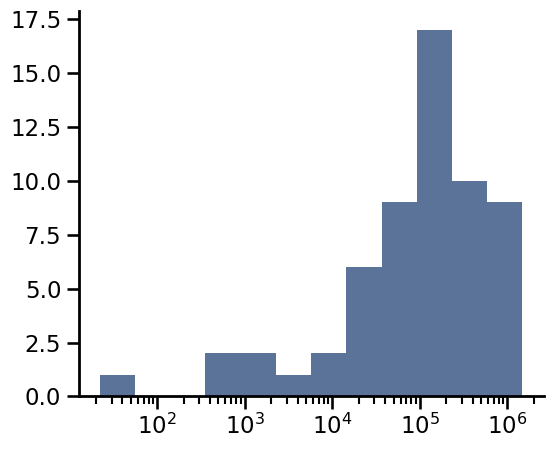

In [15]:
# Check the distribution of risk factor papers
print('Test for normality (log-spaced) \t t-val: {:1.2f} \t p-val {:1.2f}'.format(\
      *normaltest(np.log10(counts.terms['A'].counts))))
import os
if not os.path.exists(figs_dir):
    os.makedirs(figs_dir)

plot_count_hist(counts.terms['A'].counts, bins=12,
                save_fig=SAVE_FIG, file_name='blue_health_factor_hist' + SAVE_EXT,
                directory=figs_dir, save_kwargs={'transparent' : True})

### Association Articles

In [16]:
# Check the total number of association papers
print('The total # of association papers is: \t {:.0f}'.format(sum(counts.terms['B'].counts)))

The total # of association papers is: 	 109542


The total # of association papers is: 	 109542
Test for normality (log-spaced) 	 t-val: nan 	 p-val nan


/var/folders/3k/x1gnksmn1n10tcwjbtrk7ch80000gn/T/ipykernel_27710/2095494926.py:7: RuntimeWarning: divide by zero encountered in log10
  *normaltest(np.log10(counts.terms['B'].counts))))
/Users/davidgallardo-pujol/Documents/GitHub/BlueHealthKnowledge/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1158: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


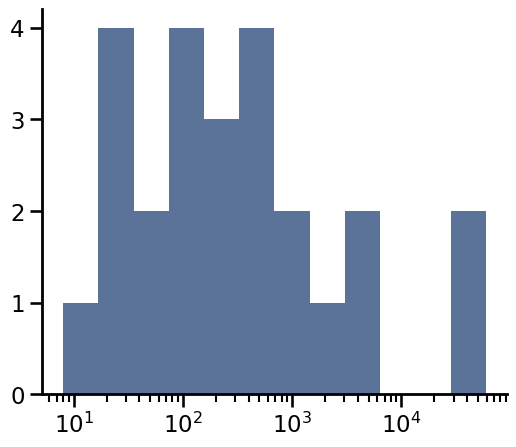

In [17]:
# Check the total number of association papers
print('The total # of association papers is: \t {:.0f}'.format(sum(counts.terms['B'].counts)))

# Check the distribution of association papers
if len(counts.terms['B'].counts) >= 8:
    print('Test for normality (log-spaced) \t t-val: {:1.2f} \t p-val {:1.2f}'.format(\
          *normaltest(np.log10(counts.terms['B'].counts))))
else:
    print("Not enough samples to perform normality test (requires at least 8).")

plot_count_hist(counts.terms['B'].counts, bins=12,
                save_fig=SAVE_FIG, file_name=name + '_assoc_hist' + SAVE_EXT,
                directory=figs_dir, save_kwargs={'transparent' : True})


### Co-occurence Numbers

In [18]:
# Check how many co-occurence values are zero
n_coocs = np.multiply(*counts.counts.shape)
n_zero = sum(np.ravel(counts.counts) == 0)
percent_zero = (n_zero / n_coocs) * 100

In [19]:
# Print out completeness of the co-occurence matrix
print('Percent zero: \t\t% {:4.2f}'.format(percent_zero))
print('Percent non-zero: \t% {:4.2f}'.format(100 - percent_zero))

Percent zero: 		% 54.01
Percent non-zero: 	% 45.99


In [20]:
# Print out summaries of the co-occurence data
print('The total number of cooc values is: \t{:d}'.format(sum(np.ravel(counts.counts))))
print('The median number of cooc values is: \t{:2.2f}'.format(np.median(np.ravel(counts.counts))))

The total number of cooc values is: 	133669
The median number of cooc values is: 	0.00


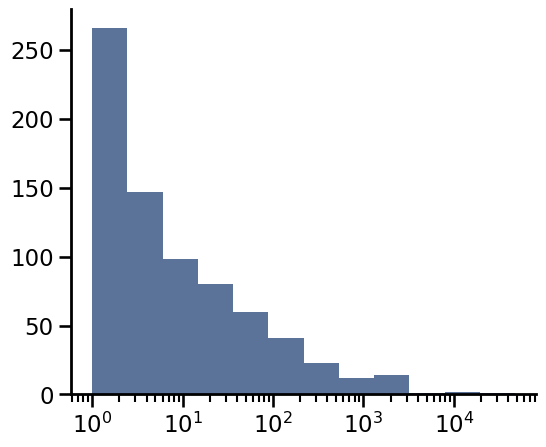

In [21]:
# Plot the distribution of (non-zero) co-occurence values
plot_count_hist(np.ravel(counts.counts), bins=12, log=True)

# Check Counts

In [22]:
# Check the terms with the most papers
counts.check_top(dim='A')
counts.check_top(dim='B')

The most studied term is  'Self-transcendence'  with  1484386  articles.
The most studied term is  'apnea'  with  59157  articles.


In [23]:
# Check how many papers were found for each risk factor term
counts.check_counts(dim='A')

The number of documents found for each search term is:
  'Mental health'                -    739873
  'Affect balance'               -    128688
  'Psychological distress'       -    174190
  'Perceived stress'             -   1142015
  'Anxiety'                      -    293740
  'Depression'                   -    466944
  'Rumination'                   -     22569
  'Post-traumatic stress'        -     42451
  'Fear of water'                -        22
  'Resilience'                   -     64346
  'Self-esteem'                  -     29040
  'Self-efficacy'                -     52606
  'Mindfulness'                  -     18378
  'Nature connectedness'         -     51214
  'Awe'                          -     98435
  'Attention restoration'        -      1020
  'Sleep quality'                -    235497
  'Social wellbeing'             -    541524
  'Pro-environmental behavior'   -       892
  'Cognitive function'           -    226370
  'Executive function'           -    621726


In [24]:
# Check how many papers were found for each association term
counts.check_counts(dim='B')

The number of documents found for each search term is:
  'contemplation of water'               -    6117
  'sitting by the sea'                   -     137
  'mindfulness by the sea'               -    2523
  'coastal strolling'                    -     451
  'birdwatching (coastal)'               -      22
  'rockpooling'                          -     395
  'beach clean-up'                       -     442
  'wading'                               -     390
  'sea dipping'                          -     182
  'sunbathing (marine setting)'          -       0
  'leisure swimming'                     -      61
  'snorkeling (gentle)'                  -     116
  'stand-up paddleboarding (leisure)'    -      17
  'recreational kayaking (sit-on-top)'   -   31928
  'sailing as passenger'                 -      38
  'shore angling'                        -     122
  'rowboat leisure'                      -     306
  'open-water swimming (training)'       -     264
  'sea kayaking expedition'

In [25]:
# Check the most commonly associated association term for each risk factor
counts.check_data()

For  'Mental health'               the highest association is  'apnea'                               with        3110
For  'Affect balance'              the highest association is  'apnea'                               with         597
For  'Psychological distress'      the highest association is  'apnea'                               with         764
For  'Perceived stress'            the highest association is  'apnea'                               with        2156
For  'Anxiety'                     the highest association is  'apnea'                               with         970
For  'Depression'                  the highest association is  'apnea'                               with        2560
For  'Rumination'                  the highest association is  'apnea'                               with          21
For  'Post-traumatic stress'       the highest association is  'apnea'                               with         121
For  'Fear of water'               the highest associati

In [26]:
# Check the most commonly associated risk factor for each term
counts.check_data(dim='B')

For  'contemplation of water'              the highest association is  'Attention'                   with         280
For  'sitting by the sea'                  the highest association is  'Blood pressure'              with          26
For  'mindfulness by the sea'              the highest association is  'Perceived stress'            with         235
For  'coastal strolling'                   the highest association is  'Physical function'           with          86
For  'birdwatching (coastal)'              the highest association is  'Social wellbeing'            with           1
For  'rockpooling'                         the highest association is  'Perceived stress'            with          12
For  'beach clean-up'                      the highest association is  'Attention'                   with          12
For  'wading'                              the highest association is  'Infection'                   with          37
For  'sea dipping'                         the highest a

## Select risk factors with enough articles

In [27]:
# Check how many risk factors currently
counts.terms['A'].n_terms

60

In [28]:
# Drop ERPs without a target number of articles
counts.drop_data(N_RISK_FACTORS, dim='A')
print(counts.terms['A'].n_terms)

57


## Group Level Plots

In [29]:
# Compute the normalized score (percent association)
counts.compute_score('normalize', dim='A')

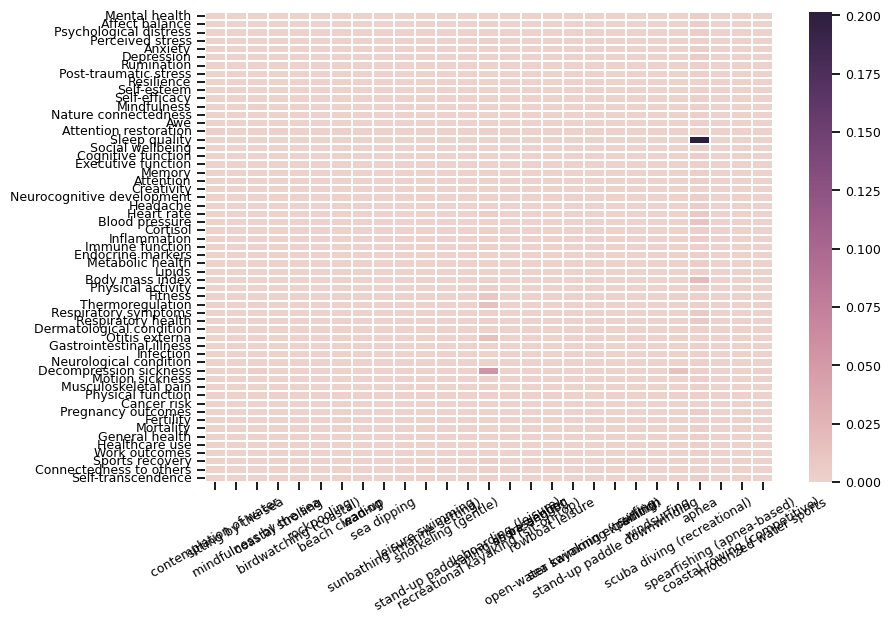

In [30]:
# Plot the matrix of percent associations - risk factors & terms
plot_matrix(counts, linewidths=matrix_linewidths, figsize=(10, 8),
            save_fig=SAVE_FIG, file_name=name + '_associations' + SAVE_EXT,
            directory=figs_dir, save_kwargs={'transparent' : True})

import matplotlib.pyplot as plt
plt.xticks(rotation=30);
import matplotlib.pyplot as plt

fig = plt.gcf()  # get current figure
for ax in fig.axes:
    plt.setp(ax.get_xticklabels(), fontsize=9)
    plt.setp(ax.get_yticklabels(), fontsize=9)


non-finite totals: 0 NaN | 0 Inf
shape: (57, 27)
saved: ../data/figures/counts/blue_health_activities_clustermap.png


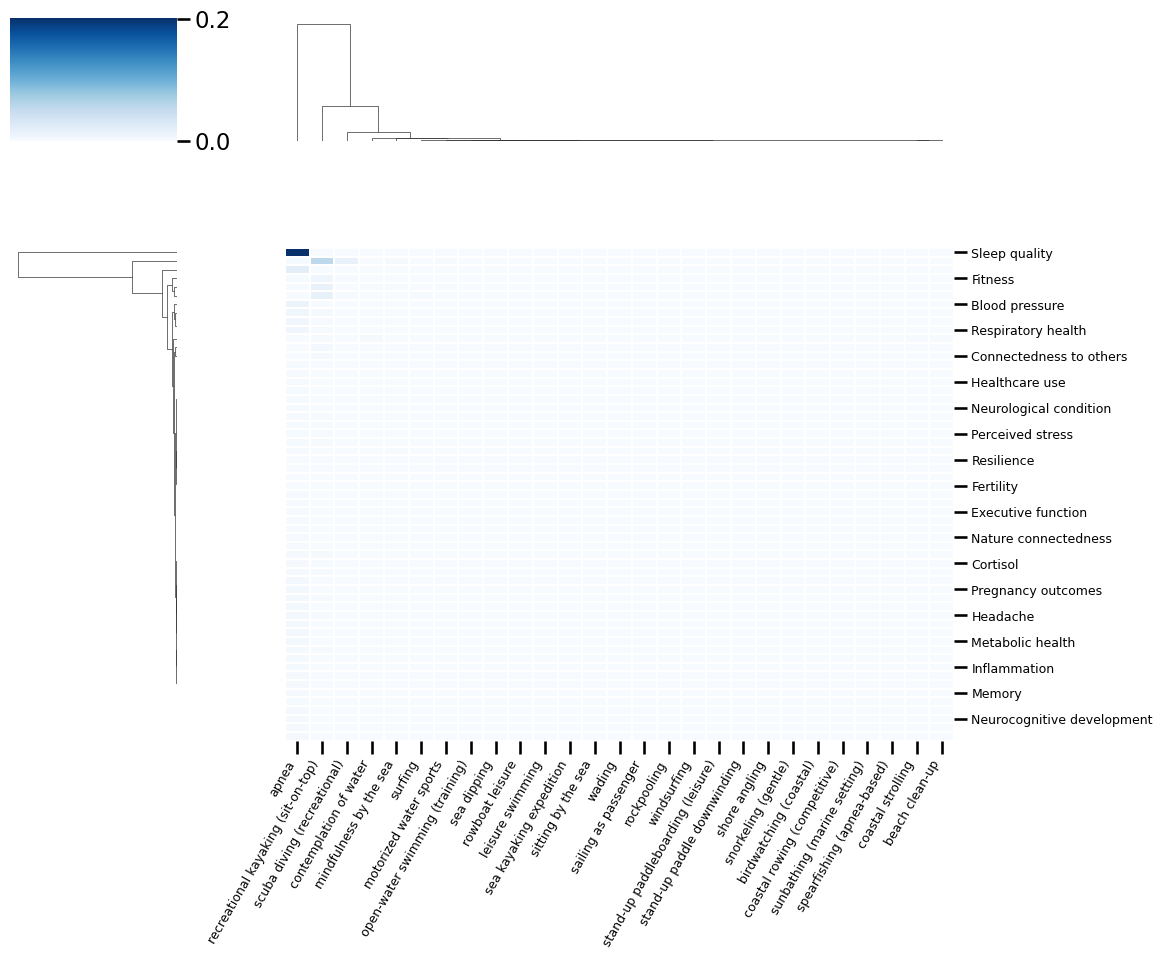

In [33]:
# Build a clustermap from the normalized score matrix and save it

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame from LISC counts (normalized earlier)
df = pd.DataFrame(
    counts.score,
    index=counts.terms['A'].labels,
    columns=counts.terms['B'].labels
)

# Basic diagnostics (optional)
M = df.to_numpy(dtype=float)
print("non-finite totals:", np.isnan(M).sum(), "NaN |", np.isinf(M).sum(), "Inf")
print("shape:", df.shape)

# Plot (use a valid colormap name such as 'Blues')
g = sns.clustermap(
    df,
    cmap="Blues",
    linewidths=matrix_linewidths,
    figsize=(12, 10)
)
plt.setp(g.ax_heatmap.get_xticklabels(), fontsize=9, rotation=60, ha='right')
plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=9)
plt.tight_layout()

# Ensure an output directory of type Path and save the figure
figs_dir = Path(figs_dir) if not isinstance(figs_dir, Path) else figs_dir
figs_dir.mkdir(parents=True, exist_ok=True)

# Ensure consistent file naming
SAVE_EXT = ".png"  # must start with a dot
out = figs_dir / f"{name}_clustermap{SAVE_EXT}"
g.figure.savefig(out, dpi=300, transparent=True, bbox_inches="tight")
print("saved:", out)


### Similarity Measure

In [34]:
# Calculate similarity between all risk factors (based on term association percents)
counts.compute_score('similarity', 'A')

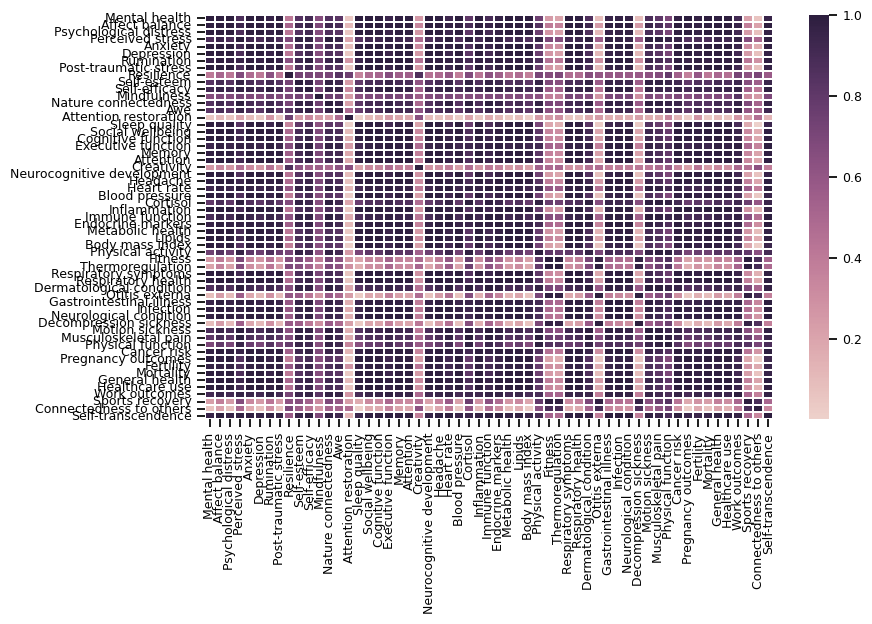

In [35]:
# Plot similarity matrix between risk factors
plot_matrix(counts, linewidths=matrix_linewidths, figsize=(10, 7),
            save_fig=SAVE_FIG, file_name=name + '_similarity' + SAVE_EXT,
            directory=figs_dir, save_kwargs={'transparent' : True})

import matplotlib.pyplot as plt
plt.tight_layout()

fig = plt.gcf()  # get current figure
for ax in fig.axes:
    plt.setp(ax.get_xticklabels(), fontsize=9)
    plt.setp(ax.get_yticklabels(), fontsize=9)


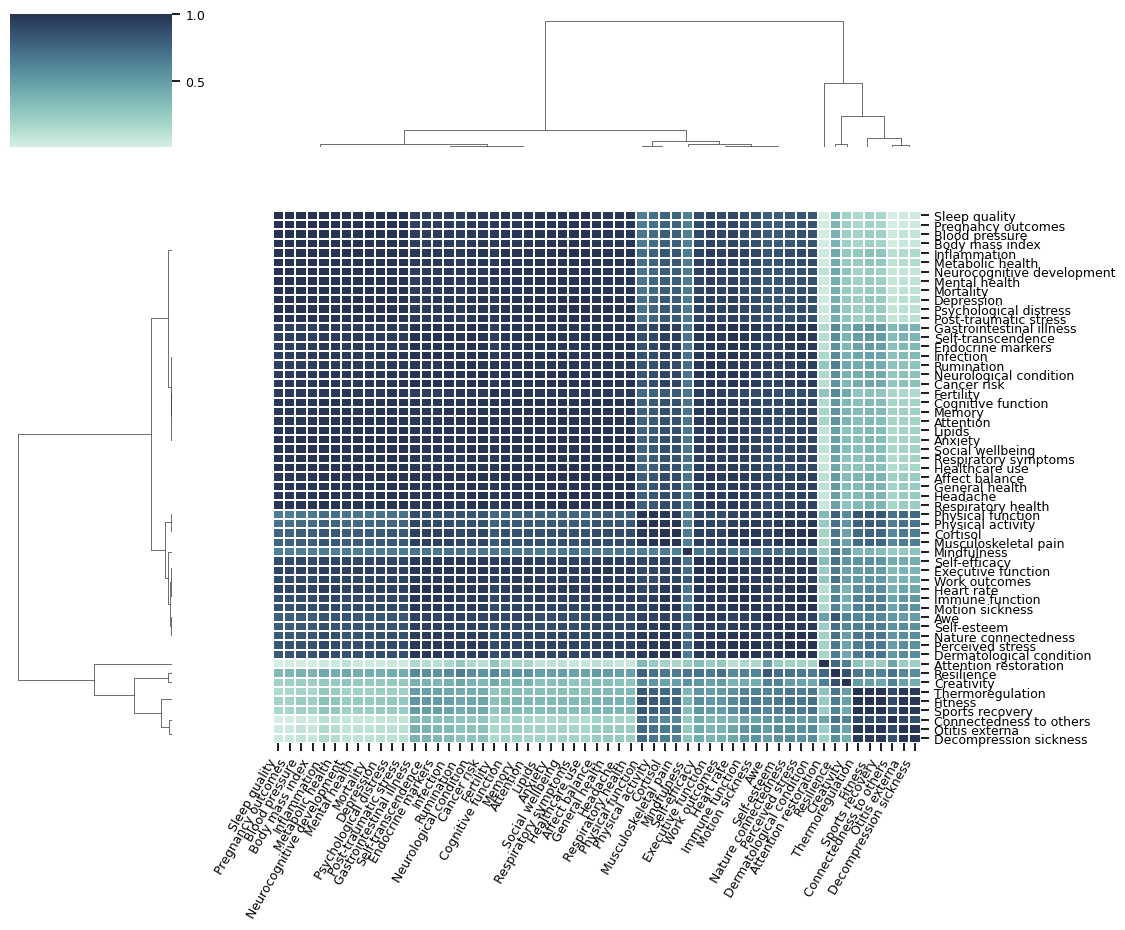

In [36]:
# Plot a clustermap, clustering risk factors based on similarity
plot_clustermap(counts, attribute='score', cmap='blue', 
                linewidths=matrix_linewidths, figsize=(12, 10),
                save_fig=SAVE_FIG, file_name=name + '_similarity_cluster' + SAVE_EXT,
                directory=figs_dir, save_kwargs={'transparent' : True})

import matplotlib.pyplot as plt
plt.tight_layout()

fig = plt.gcf()  # get current figure
for ax in fig.axes:
    plt.setp(ax.get_xticklabels(), fontsize=9)
    plt.setp(ax.get_yticklabels(), fontsize=9)


### Association Score

In [37]:
# Calculate association between all ERPs
counts.compute_score('association')

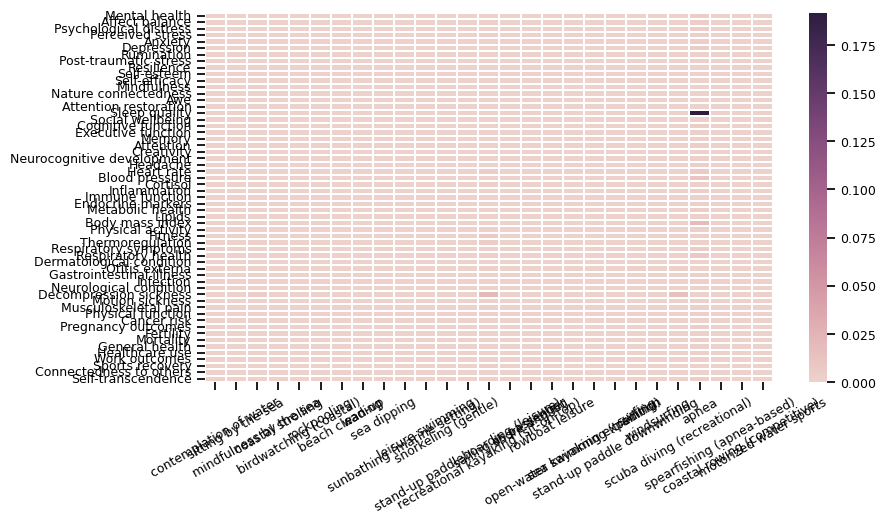

In [38]:
# Plot similarity matrix between terms
plot_matrix(counts, linewidths=matrix_linewidths, figsize=(10, 7),
            save_fig=SAVE_FIG, file_name=name + '_associations' + SAVE_EXT,
            directory=figs_dir, save_kwargs={'transparent' : True})

import matplotlib.pyplot as plt
plt.xticks(rotation=30);

fig = plt.gcf()  # get current figure
for ax in fig.axes:
    plt.setp(ax.get_xticklabels(), fontsize=9)
    plt.setp(ax.get_yticklabels(), fontsize=9)

### Dendrograms

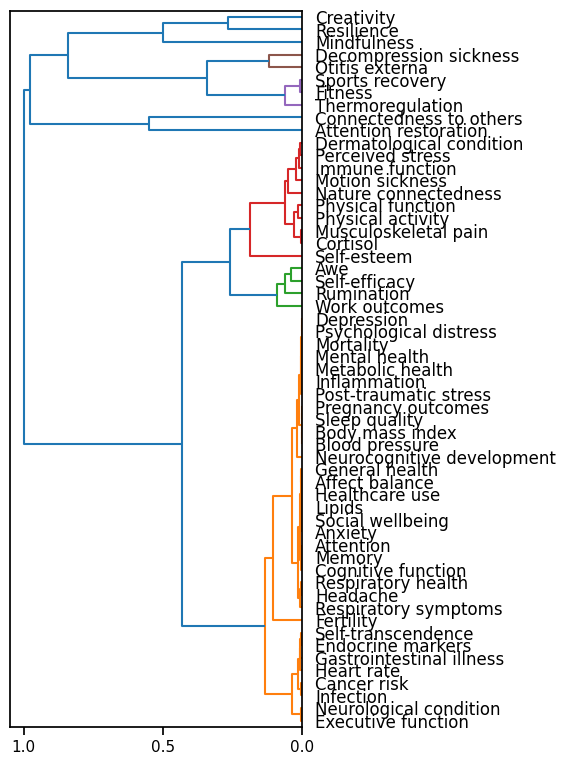

In [39]:
# Plot dendrogram of risk factors, based on percent associations with terms
plot_dendrogram(counts, attribute='score', figsize=(6, 8),
                save_fig=SAVE_FIG, file_name=name + '_erp_dendro' + SAVE_EXT,
                directory=figs_dir, save_kwargs={'transparent' : True})

saved: ../data/figures/counts/blue_health_activities_term_dendro.png


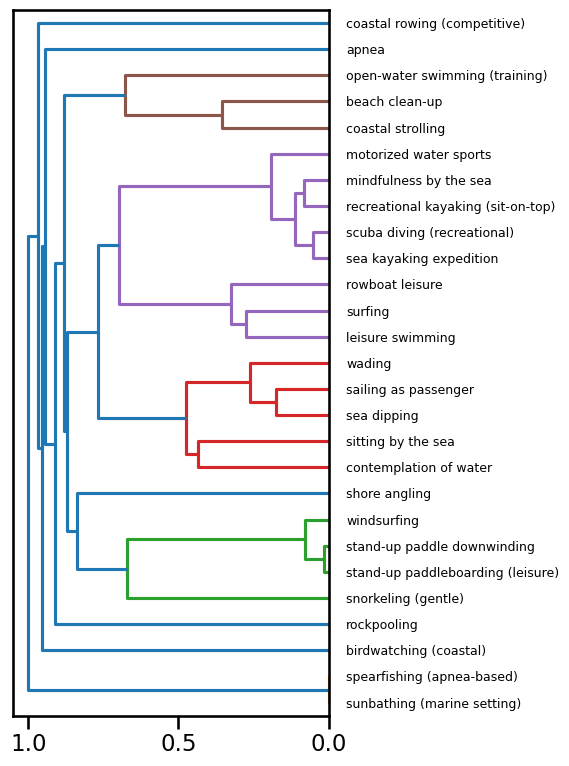

In [44]:
# Robust dendrogram that keeps zero rows (no row dropping), with safe indexing
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

# 1) Build score matrix and choose orientation
transpose = True  # True → cluster terms (dimension B); False → cluster factors (dimension A)
S = np.asarray(counts.score, dtype=float)
X = S.T if transpose else S
labels = list(counts.terms['B'].labels if transpose else counts.terms['A'].labels)

# 2) Clean non-finite values (keep zeros)
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

# 3) Safe cosine similarities with zero-row handling
eps = 1e-12
row_norm = np.linalg.norm(X, axis=1)
den = np.where(row_norm[:, None] > 0, row_norm[:, None], 1.0)  # avoid division by zero
Xn = X / den  # zero rows remain all zeros

# cosine similarity
Sim = Xn @ Xn.T
Sim = np.clip(Sim, -1.0, 1.0)

# adjust similarities for zero rows using explicit index arrays
zi = np.where(row_norm <= eps)[0]        # indices of zero rows
nzi = np.where(row_norm > eps)[0]        # indices of non-zero rows
if zi.size > 0:
    # zero ↔ non-zero similarity = 0  → distance 1
    if nzi.size > 0:
        Sim[np.ix_(zi, nzi)] = 0.0
        Sim[np.ix_(nzi, zi)] = 0.0
    # zero ↔ zero similarity = 1      → distance 0  (cluster zeros together)
    Sim[np.ix_(zi, zi)] = 1.0

# convert to distances
D_full = 1.0 - Sim
np.fill_diagonal(D_full, 0.0)

# condensed form for SciPy linkage
from scipy.spatial.distance import squareform
D = squareform(D_full, checks=False)

# 4) Hierarchical clustering and plot
Z = linkage(D, method="average", optimal_ordering=True)
fig, ax = plt.subplots(figsize=(6, 8))
orientation = "left" if transpose else "top"
dendrogram(Z, labels=labels, orientation=orientation, leaf_font_size=9, ax=ax)
plt.tight_layout()

# 5) Save figure (Path-safe)
figs_dir = Path(figs_dir) if not isinstance(figs_dir, Path) else figs_dir
figs_dir.mkdir(parents=True, exist_ok=True)
SAVE_EXT = ".png" if not isinstance(globals().get("SAVE_EXT", ".png"), str) else globals().get("SAVE_EXT")
name = globals().get("name", "blue_health_exposure_metrics")
out = figs_dir / f"{name}_term_dendro{SAVE_EXT}"
if globals().get("SAVE_FIG", True):
    fig.savefig(out, dpi=300, transparent=True, bbox_inches="tight")
    print("saved:", out)
